In [33]:
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*4

In [34]:
train_df = pd.read_csv("s.csv")
mask = (train_df['ENGLISH'].str.len()>20) & (train_df['ENGLISH'].str.len()<200)
train_df = train_df.loc[mask]

train_df.head()

,ENGLISH,bodo
0,Two of the best trains viz. Shatabdi express (between Delhi and Bhopal) and Taj Express (between Delhi and Gwalior) are available to access Agra.,रोखोमनै साबसिन त्रेइन जेरै- सताबदि अक्सप्रेस (देलही आरो भुपालनि गेजेराव) आरो ताज एक्सप्रेसनि (दिल्ली आरो गवालिरनि गेजेराव) आग्रासिम हाबग्रा लामाया थोजासे रोखोमनि।
1,"Agra, on cross roads of national highways 2, 3 and 11, is excellently connected to all parts of the country.","राजा लामानि 2, 3, आरो 11 आ आग्रासिम थांनो थाखाय हादोरनि गासैबो रोखोमनि लामाफोरजों जोबोद मोजाङै फोनांजाबनाय।"
2,Kheria Airport (Airport of Agra) is about 6 km from the Agra city centre and is easily accessible by taxis and auto rickshaws at nominal rates.,सेरिया बिरखं गाथोना (आग्रानि बिरखं गाथोन) आरो नोगोरनिफ्राय 6.कि.मि. गोजानाव आरो जायगायावनो मोलाय अटʼ रिक्सायाव होनांनाय बेसेनाबो थि जखानि।
3,"Agra is well connected by excellent train services to Delhi such as The Shatabdi Express (2 hrs), Taj Express (2. 5 hrs), Intercity Express (3 hrs).","आग्रानिफअराय दिल्लीसिम थांनो थाखाय त्रेइननि फोनांजाब राहाया जोबोद मोजां लोगोसे मखʼजाथाव त्रेइनफोरा जाबाय- साताबदि एक्स-प्रेस( 2 घन्टा) ताज अक्सप्रेस (2,5 घन्टा) इन्टारसिति अक्सप्रेस (3 घन्टा)।"
4,"Agra is the one of the prominent destinations of the World Tourism map with three heritage monuments, Taj Mahal, Red Fort & Fatehpur Sikri.",बुहुमनि दावबायारिफोरनि थाखाय आग्रानि मुंदांखा नायनो गोनां मान-सावगारिजों लोगोसे मोनथाम रोखोमनि गोसोखांथिया- ताज महल रेद फर्ट आरो फातेहपुर सिकरि।


In [35]:
pd.set_option('display.max_colwidth', None)

In [36]:

train_df.drop_duplicates()

,ENGLISH,bodo
0,Two of the best trains viz. Shatabdi express (between Delhi and Bhopal) and Taj Express (between Delhi and Gwalior) are available to access Agra.,रोखोमनै साबसिन त्रेइन जेरै- सताबदि अक्सप्रेस (देलही आरो भुपालनि गेजेराव) आरो ताज एक्सप्रेसनि (दिल्ली आरो गवालिरनि गेजेराव) आग्रासिम हाबग्रा लामाया थोजासे रोखोमनि।
1,"Agra, on cross roads of national highways 2, 3 and 11, is excellently connected to all parts of the country.","राजा लामानि 2, 3, आरो 11 आ आग्रासिम थांनो थाखाय हादोरनि गासैबो रोखोमनि लामाफोरजों जोबोद मोजाङै फोनांजाबनाय।"
2,Kheria Airport (Airport of Agra) is about 6 km from the Agra city centre and is easily accessible by taxis and auto rickshaws at nominal rates.,सेरिया बिरखं गाथोना (आग्रानि बिरखं गाथोन) आरो नोगोरनिफ्राय 6.कि.मि. गोजानाव आरो जायगायावनो मोलाय अटʼ रिक्सायाव होनांनाय बेसेनाबो थि जखानि।
3,"Agra is well connected by excellent train services to Delhi such as The Shatabdi Express (2 hrs), Taj Express (2. 5 hrs), Intercity Express (3 hrs).","आग्रानिफअराय दिल्लीसिम थांनो थाखाय त्रेइननि फोनांजाब राहाया जोबोद मोजां लोगोसे मखʼजाथाव त्रेइनफोरा जाबाय- साताबदि एक्स-प्रेस( 2 घन्टा) ताज अक्सप्रेस (2,5 घन्टा) इन्टारसिति अक्सप्रेस (3 घन्टा)।"
4,"Agra is the one of the prominent destinations of the World Tourism map with three heritage monuments, Taj Mahal, Red Fort & Fatehpur Sikri.",बुहुमनि दावबायारिफोरनि थाखाय आग्रानि मुंदांखा नायनो गोनां मान-सावगारिजों लोगोसे मोनथाम रोखोमनि गोसोखांथिया- ताज महल रेद फर्ट आरो फातेहपुर सिकरि।
...,...,...
9094,"ALMORA Spread over a horseshoe ridge at a height of 1,646 meters is Almora, once the centre of Kumaoni culture and the capital of the Chand dynasty.","आलमराया 1,656 मिटार गोजौवाव इंराजी महराव हाजो थिखिनियाव गोसारना दं, जाय मोनसे समाव कुमावनि हारिमुनि थावनिमोन आरो चाण्ड राजफोलेरनि राजथावनिमोन।"
9095,To the north of the ridge is a breathtaking view of the trident shaped Trishul peaks.,साहानि खरʼनिफ्राय त्रिसुल महराव थानाय त्रिसुल हाजो थिखिनिखौ समायनायै नुनो मोनो।
9096,"On the edges of Almora the Koshi and Suyal rivers cut through the mountains, while the hill sides are lined with fir and pine forests.",आलमरा जिंजों कसि आरो सुयाल दैमाया सिंखावलांदों आरो हाजो जिङा देबदारु आरो पाइन बिफांफोरजों सारि सारि जाना दं।
9097,"Away from the main tourist humdrum of Nainital or Ranikhet, Almora has retained much of its traditional values and old world charm.",नाइनिटाल आरो रानिखेटनिफ्राय गोजानाव खम अनजिमानि दावबायारिफोर अलमराहा दोरोङारि नेम खान्थि आरो गोजाम मुलुगारि समायनाथि दं।


In [37]:
# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'ENGLISH' column
train_df['ENGLISH'] = train_df['ENGLISH'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove unwanted characters, convert text to lowercase, and remove nan values for the 'बड़ो' column
train_df['bodo'] = train_df['bodo'].apply(lambda x: re.sub(r'[^a-zA-Z\u0900-\u097F\s]', '', str(x).lower()) if pd.notnull(x) else '')

# Remove punctuation for the 'ENGLISH' column
train_df['ENGLISH'] = train_df['ENGLISH'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove punctuation for the 'बड़ो' column
train_df['bodo'] = train_df['bodo'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Remove extra whitespace for the 'ENGLISH' column
train_df['ENGLISH'] = train_df['ENGLISH'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove extra whitespace for the 'बड़ो' column
train_df['bodo'] = train_df['bodo'].apply(lambda x: re.sub(r'\s+', ' ', x.strip()))

# Remove rows with empty values
train_df.replace('', np.nan, inplace=True)
train_df.dropna(subset=['ENGLISH', 'bodo'], inplace=True)

# Save the cleaned data to a new CSV file
train_df.to_csv('sd.csv', index=False)


KeyboardInterrupt: 

In [ ]:
train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Save the training and testing data to separate CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

In [ ]:
train_df=pd.read_csv('train_data.csv')
train_df

,ENGLISH,bodo
0,after two years of fighting the aztecs were defeated,बोसोरनै दावहा नांनायनि उनाव एजटेकफोरा जेनदोंमोन।
1,there are numerous reports of marx going on pubcrawls down oxford street,अक्सफर्ड स्ट्रिड एना लामायाव मार्क्सा थांलायफैलाय खालामनायनि गोबां फोरमायथि दं।
2,sometime between april and april ponce de len waded ashore on the northeast coast of florida possibly near presentday st augustine,एप्रिल आरो एप्रिल नि गेजेरा माब्लाबा समाव प्लिरिदानि साहा सानजा बोरिमा सेरफाङाव पन्स दि लिउना गावनि जायगाखौ लादोंमोन जानोहागौ आथिखालाव बेयो सेन्ट आगुस्थिननि सेराव।
3,once that consistency is reached the milk is allowed to cool and oranges added,बैखौ मावखांनाय लोगोलोगो गायखेरखौ गसु खालामनाय जायो नारेंकमलाफोरखौ गलायनाय जायो।
4,accommodation in cozy nook includes thatched huts tree houses and trendy cottages with quirky bathrooms,कजि नुकाव थानाय खाबुफोरा जाबाय थोरिनि न दंखानि न आरो सरासनस्रा बाहायजाथाव दुगैग्रा न गोनां ट्रेनदि खथा।
...,...,...
6476,the honey tastes quite different from what you find in the markets elsewhere and as such has a very distinct flavour that many claim complete addition to,बेरे मोदैआ गुबुन हाथायफोराव मोननायनिख्रुइ थारै आलादा रोखोमनि थावनाय गोनां आरो बेखौ गोबां मानसियानो आलादा रोखोमनि जोबोर थावनाय गोनां होनना दाबि दैखाङो।
6477,bandhani is an intricate and time consuming process of tie and dyeing fabrics this process takes six months to a year for some saris and even the simplest patterns can take more than a month,गोबां समावनो बांसिन बाहाय बोनाय दानाय लुनाय खसाब बन्धनिया मोनसे समायना बे राहायै दानाय सारिया माब्लाबा द दाननिफ्राय बोसोरसे सम लायो आरो गोरलै दाथायनि दानाया दानसेनि बारा लायो।
6478,the country is geographically divided into the amazon the highlands the coast and the galpagos islands,बे हादरखौ भुमखौराङारि बिथिंजों आमाजान गोजौ हा ओनसोल लैथोनि बोरि ओनसोल आरो गलापागस दिब बाहागोआव राननाय जादों।
6479,select from the catch of the day lobsters giant crabs tiger prawn and ask them to grill it for you,सानसेयाव मोननायखौ सायावनो गेदेर खांख्राय नाथुर बन्दाखौ बिनो हागौ आरो बिसोरखौ नोंनि थाखाय थियारि खालाम होनो हागौ।


Tokenizer

In [ ]:
eng = train_df['ENGLISH']
hind = train_df['bodo']
eng = eng.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
hind = hind.apply(lambda x: "<SOS> "+ str(x) + " <EOS>")
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
hind_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
eng_tokenizer.fit_on_texts(eng)
hind_tokenizer.fit_on_texts(hind)
inputs = eng_tokenizer.texts_to_sequences(eng)
targets = hind_tokenizer.texts_to_sequences(hind)
print(eng_tokenizer)
print(hind_tokenizer)

In [ ]:
ENCODER_VOCAB = len(eng_tokenizer.word_index) + 1
DECODER_VOCAB = len(hind_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

14745 27507


In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [ ]:
print(inputs)
print(targets)

tf.Tensor(
[[    3   106   100 ...     0     0     0]
 [    3    39    12 ...     0     0     0]
 [    3  1194    90 ...     0     0     0]
 ...
 [    3     2   151 ...     0     0     0]
 [    3 14742    14 ...     0     0     0]
 [    3     2    44 ...     0     0     0]], shape=(6481, 100), dtype=int64)
tf.Tensor(
[[   2 3829  416 ...    0    0    0]
 [   2 2974 8748 ...    0    0    0]
 [   2 2431    4 ...    0    0    0]
 ...
 [   2    5 1084 ...    0    0    0]
 [   2 1151 8400 ...    0    0    0]
 [   2   11    7 ...    0    0    0]], shape=(6481, 100), dtype=int64)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Transformer Model

The next several blocks of code contain the vanilla Transformer model.

If you want to know about what they are and how they work I suggest this video: https://www.youtube.com/watch?v=4Bdc55j80l8

It does an excellent job of giving an overview about them and helped me in understanding them.

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 2000

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
optimizer = Adam(learning_rate=0.0001)


Text(0.5, 0, 'Train Step')

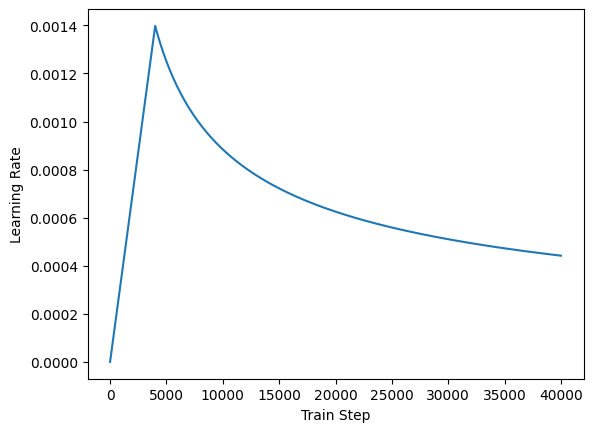

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
     ckpt.restore(ckpt_manager.latest_checkpoint)
     print ('Latest checkpoint restored!!')

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
        if (epoch + 1) % 5 == 0:
             ckpt_save_path = ckpt_manager.save()
             print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 10.2224 Accuracy 0.0000
Epoch 1 Loss 9.8063 Accuracy 0.0574
Time taken for 1 epoch: 609.5783112049103 secs

Epoch 2 Batch 0 Loss 9.3289 Accuracy 0.0574
Epoch 2 Loss 9.0826 Accuracy 0.0580
Time taken for 1 epoch: 569.3887691497803 secs

Epoch 3 Batch 0 Loss 8.7411 Accuracy 0.0580
Epoch 3 Loss 8.6229 Accuracy 0.0583
Time taken for 1 epoch: 583.3893785476685 secs

Epoch 4 Batch 0 Loss 8.4749 Accuracy 0.0583
Epoch 4 Loss 8.3790 Accuracy 0.0584
Time taken for 1 epoch: 575.3674850463867 secs

Epoch 5 Batch 0 Loss 8.2304 Accuracy 0.0584
Saving checkpoint for epoch 5 at checkpoints\ckpt-1
Saving checkpoint for epoch 5 at checkpoints\ckpt-2
Saving checkpoint for epoch 5 at checkpoints\ckpt-3
Saving checkpoint for epoch 5 at checkpoints\ckpt-4
Saving checkpoint for epoch 5 at checkpoints\ckpt-5
Saving checkpoint for epoch 5 at checkpoints\ckpt-6
Saving checkpoint for epoch 5 at checkpoints\ckpt-7
Saving checkpoint for epoch 5 at checkpoints\ckpt-8
Saving checkpoint for epoch

KeyboardInterrupt: 

In [ ]:
def evaluate(text):
    text = eng_tokenizer.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(text[0], 0)

    decoder_input = [hind_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == hind_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(eng_text):
    hind_text = evaluate(text=eng_text)[0].numpy()
    hind_text = np.expand_dims(hind_text[1:], 0)  
    return hind_tokenizer.sequences_to_texts(hind_text)[0]

In [ ]:
translate("That politics , in retrospect , was rooted in a false ideology")

In [ ]:
translate("Above the tombs is a Cairene lamp, the flame of which is supposed to never burn out.")


In [ ]:
import csv
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def read_csv_file(file_path):
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            sentences.append(row)
    return sentences

def compute_bleu_score(reference_sentences, predicted_sentences):
    references = [[ref.split()] for ref in reference_sentences]  # Split sentences into words
    hypotheses = [hyp.split() for hyp in predicted_sentences]  # Split sentences into words
    
    smooth_func = SmoothingFunction().method4  # Apply smoothing to BLEU score
    
    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smooth_func)
    return bleu_score

# Load testing data from CSV files

test_file = r'test_data.csv'

test_data = read_csv_file(test_file)

# Assuming the source and target translations are stored in columns 0 and 1, respectively
test_source_sentences = [row[0] for row in test_data]
test_target_sentences = [row[1] for row in test_data]

# Translate the source sentences from the test set
predicted_sentences = [translate(src) for src in test_source_sentences]

print("Translated")
# Compute BLEU score on the test set using the training set as references
bleu = compute_bleu_score(test_target_sentences, predicted_sentences)

print(f"BLEU score: {bleu}")

In [ ]:
(test_target_sentences, predicted_sentences)